# This file will serve as the main testing ground for a variety of signals for the CRSP data set

## The multiple strategies are the underlying:

### 1. Univariate Strategies
   
### 2. Multivariate Strategies
   
### 3. NN-based methodologies
   
### 4. Others? (eg. from academic literature)

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels as sm
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import *
from sklearn.kernel_ridge import *
import math
import scipy
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
data  = pd.read_csv('data/returns.csv')
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)

# Univariate strategies
* Simple strategies
    + moving average
    + MACD -> DONE
* forecasting strategies (requires cross-validation procedure)
    + ARMA
    + KRR -> IN PROGRESS
    + Ornstein-Uhlenbeck

In [3]:
def macd(ret, long=26, short=12, signal_span=9, plot=False):

    short_signal = ret.ewm(span=short, adjust=False).mean()
    long_signal = ret.ewm(span=long, adjust=False).mean() 
    macd = short_signal - long_signal
    signal = macd.ewm(span=signal_span, adjust=False).mean()

    position = np.zeros(len(ret))
    
    for i in range(len(ret)):
        
        if macd[i] >= 0:
            if macd[i] > signal[i]:
                position[i] = 1
            else: position[i] = 0
        
        else:
            if macd[i] < signal[i]:
                position[i] = -1
            else: position[i] = 0
    
    if plot==True:
        %matplotlib widget
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(ret.index[:100],signal[:100], label = 'signal', color='g')
        ax.plot(ret.index[:100],macd[:100], label = 'macd', color = 'b')
        ax.legend(loc=1)
        ax.set_xlabel("time")
        ax.set_ylabel("MACD/SIGNAL")
        
        months = mdates.MonthLocator()
        ax.xaxis.set_major_locator(months) 
        fig.autofmt_xdate()
        
        ax2 = ax.twinx()
        ax2.stem(stock.index[:100],position[:100])
        ax2.set_ylabel("position (1 for long, 0 for none, -1 for short)")
        ax2.set_ylim(-3,3)
        ax.set_title("MACD strategy visualised with positions as stems for first 100 observations")
        plt.show()
    
    return (position * ret).values

def macd_signals(returns,long=26,short=12,signal_span=9):
    signals = pd.DataFrame()
    for i in range(returns.shape[1]):
        signals['signal_{}'.format(i)] = macd(returns.iloc[:,i],long,short,signal_span)
    signals.index = returns.index
    return signals



In [4]:
# auto ARIMA

# Orstein-Uhlenbeck function (mean reversion)

In [275]:
# kernel ridge
def krr(data,window_size=30):
    n = len(data)-1
    predicted_values = np.zeros(n-window_size)
    
    # rolling window
    for i in range(window_size,n):
        if i % 100 == 0: print('{} % done'.format(round(i/(n-30)*100)),end="\r")
        #    print(i)
        
        list_x = np.array(data.iloc[(i-window_size):i]).reshape(-1,1)
        list_y = np.array(data.iloc[(i-window_size+1):(i+1)]) 
        list_x_pred = np.array(data.iloc[i+1]).reshape(-1,1)
        
        parameters = {'kernel':['rbf'], 'alpha':np.arange(0.001,6,1).tolist(),'degree':np.arange(0.001,6,1).tolist()}
        clf = GridSearchCV(KernelRidge(), parameters)
        clf = clf.fit(list_x,list_y)
        pred = clf.predict(list_x_pred)
        predicted_values[i-window_size] = pred

    return predicted_values

In [ ]:
pr = krr(data.iloc[:,1])

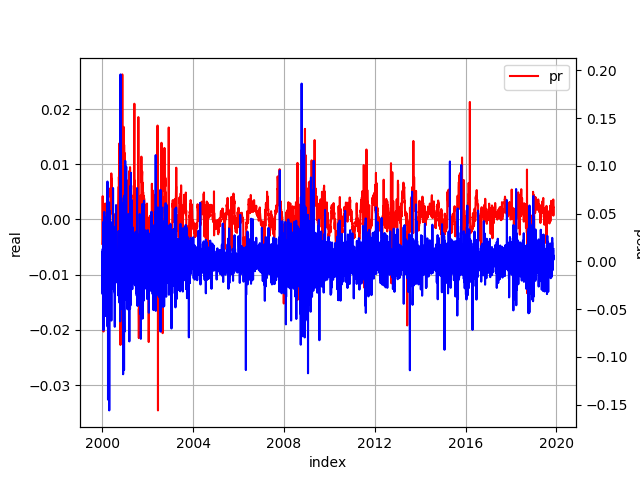

In [8]:
# performance of krr is aweful
wdw=30
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data.index[:(len(data)-wdw-1)],pr, label = 'pr', color = 'r')
ax2 = ax.twinx()
ax2.plot(data.index[:(len(data)-wdw-1)],data.iloc[1:(len(data)-wdw),1], label = 'real', color = 'b')
ax.legend(loc=0)
#ax2.legend(loc=0)
ax.grid()
ax.set_xlabel("index")
ax.set_ylabel("real")
ax2.set_ylabel("pred")
plt.show()
print()

### Testing the univariate strategies

In [124]:
# 1. test macd
stock = data.iloc[:,200]
stocks = data.iloc[:,:200]
macd_single = macd(stock, 26,12,9,)
macd_multiple = macd_signals(stocks,26,12,9)

# 2. test others ....

signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  \
date                                                                     
2000-01-03  0.000000 -0.000000  0.000000 -0.000000 -0.000000 -0.000000   
2000-01-04  0.084310  0.033780  0.083217 -0.023493  0.036610  0.039252   
2000-01-05 -0.014634 -0.010544  0.148741 -0.006173  0.010556 -0.019455   
2000-01-06  0.086538  0.033498  0.060036  0.014197  0.035515  0.010913   
2000-01-07 -0.047368 -0.013068 -0.061010  0.018373  0.038332  0.075564   
...              ...       ...       ...       ...       ...       ...   
2019-12-24  0.000951 -0.000000 -0.000000 -0.002770 -0.000000 -0.004033   
2019-12-26  0.019840  0.008197  0.044467  0.010612  0.000685 -0.000084   
2019-12-27 -0.000379  0.001828  0.000551  0.000000  0.000549 -0.000586   
2019-12-30  0.005935  0.008619 -0.000000  0.003665  0.003087  0.001589   
2019-12-31  0.007307 -0.000698  0.000000  0.000000 -0.003923  0.004690   

            signal_6  signal_7  signal_8  signal_9  
date                                                
2000-01-03 -0.000000 -0.000000 -0.000000 -0.000000  
2000-01-04  0.059355 -0.034561 -0.019242 -0.017586  
2000-01-05  0.010974  0.016432 -0.019025  0.054516  
2000-01-06  0.071913  0.041570  0.046061  0.049383  
2000-01-07 -0.013924  0.008869  0.079954 -0.000735  
...              ...       ...       ...       ...  
2019-12-24 -0.001422  0.000044 -0.002562 -0.000000  
2019-12-26  0.008518 -0.004346 -0.000000  0.000000  
2019-12-27  0.004786  0.001369  0.006948  0.003422  
2019-12-30  0.005658  0.001680  0.012848  0.005866  
2019-12-31 -0.001991 -0.003278 -0.003455 -0.004318  

[5031 rows x 10 columns]

# Multivariate Econometric
   * Vector Autoregressive (VAR) -> DONE
   * Vector error correction models (VECM)
   * Kernel Ridge Regression (KRR)

### Statistical tests
   * **Granger causality** (column var causes row var) -> rejection means good candidate for MV
       (tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (X) do not cause the other series (Y))
   * **ADF test** -> need stationarity in time series
   * **cointegration** -> establish the presence of a statistically significant connection between two or more time series

In [48]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=4):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def adfuller_test(series, signif=0.05):
    """Perform ADFuller to test for Stationarity of given series of returns and print report"""
    for name, column in series.iteritems():
        r = adfuller(column, autolag='BIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        if p_value > signif:
            print("series {} is non-stationary".format(column.name))
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    # print output if failed
    for name, trace, cvt in zip(df.columns, traces, cvts):
        if trace < cvt: print("column {} failed the cointegration test".format(name))

def multivariate_tests(data,alpha=0.05,maxlag=4, test = 'ssr_chi2test'):
    """
    data: pandas dataframe
    alpha: significance level
    maxlag: maximum number of lags for granger causality test
    test: test for granger causality
    
    what it does: prints failed adf and cointegration tests
    
    returns: granger causality matrix
    """
    adfuller_test(data, signif=alpha)
    cointegration_test(data, alpha=alpha)
    
    return grangers_causation_matrix(data, data.columns, test=test, maxlag=maxlag)

### VAR model
still requires some code optimisation

In [307]:
def var(df, window,maxlag):
    
    n = len(df)
    # initiate forecasts dataframe
    forecasts = pd.DataFrame(df,columns=df.columns+'_fc')
    
    # rolling window approach
    for i in range(window,n):
        if i % 250 == 0: print('{}% done'.format(round(i/(n-30)*100)),end="\r")
        bic_list = []
        series = df.iloc[(i-window):i,:]
        model = VAR(series)
        
        # optimal lags and fitting
        for j in np.arange(0,maxlag+1,1):
            try:
                result = model.fit(j)
                bic_list.append(result.bic)
            except:
                print("cannot deal with lag of {}, restarting with maxlag of {}".format(j,maxlag-1))
                if maxlag == 0:
                    print("window size too small relative to number of assets, please restart")
                    return 0
                else:
                    return var(df, window, maxlag-1)
        
        # final check
        if len(bic_list) == 1:
                print("window size too small relative to number of assets, please restart")
                return 0   
            
        nbr_lags = bic_list.index(min(bic_list)) + 1
        model_fitted = model.fit(nbr_lags)

        forecast_input = series.values[-nbr_lags:]
        
        fc = model_fitted.forecast(y=forecast_input, steps=2) # 2 step ahead forecast
        forecasts.iloc[i,:] = fc[0]
                
    return forecasts

In [302]:
# do the prediction for N = 10, 100, 200
stocks = data.iloc[:,:10]
pred_10 = var(stocks,window = 30,maxlag=3)
pred_10 = pred_10.dropna(how='all')
print("done\n\n")

cannot deal with lag of 2, restarting with maxlag of 2
cannot deal with lag of 2, restarting with maxlag of 1
done done




In [ ]:
stocks = data.iloc[:,:100]
pred_100 = var(stocks ,window = 300,maxlag=3)
pred_100 = pred_100.dropna(how='all')


cannot deal with lag of 2, restarting with maxlag of 2
cannot deal with lag of 2, restarting with maxlag of 1


In [ ]:
stocks = data.iloc[:,:200]
pred_200 = var(stocks ,window = 400,maxlag=3)
pred_200 = pred_200.dropna(how='all')
print("done\n\n")

plot VAR prediction results

In [ ]:
start = 0
wdw=300
index = data.index[(wdw+start):(wdw+len(pred_100))]
low = wdw+start
high = start + len(pred) + wdw
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(index,pred_100.iloc[:,2], label = 'pr', color = 'r')
ax2 = ax.twinx()
ax.plot(index,data.iloc[low:high,2], label = 'real', color = 'b')
ax.legend(loc=0)
#ax2.legend(loc=0)
ax.grid()
ax.set_xlabel("index")
ax.set_ylabel("real")
ax2.set_ylabel("pred")
plt.show()
print()

# NN-based methodologies
   * LSTM
   * CNN
   * other?